# Clustering to confirm the selection of 4 labels 

### This code is to do clustering to check if there is evidence of natural groupings for our 4 labels

### Install Packages

In [1]:
import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install sklearn
# !{sys.executable} -m pip install seaborn
# !{sys.executable} -m pip install matplot
# !{sys.executable} -m pip install plotly

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

Load data

In [2]:
data = pd.read_csv('./extracted/preprocessed_data_full.csv')

In [3]:
from sklearn.preprocessing import StandardScaler

# Helper fucntion: returns a standardized dataframe
def standardize(df):
    features = df.columns
    values_array = df.loc[:, features].values

    # Print data before standardization to compare

    print("Before Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape} \n")
    print(f"Tail of the data pre standardization: \n{values_array[-5:]} \n\n")

    # Invoke standardization

    values_array = StandardScaler().fit_transform(values_array)

    # Print data after standardization to compare

    print("After Standardization \n")
    print("Mean and Standard Deviation")
    print(f"Mean = {np.mean(values_array)} ; Standard Deviation = {np.std(values_array)}")
    print(f"Shape to verify: {values_array.shape}")
    print(f"Tail of the data post standardization: \n{values_array[-5:]}")

    return pd.DataFrame(values_array, columns=features)

In [4]:
data = standardize(data)

Before Standardization 

Mean and Standard Deviation
Mean = 159.45662601474436 ; Standard Deviation = 366.4400555708141
Shape to verify: (2110, 13) 

Tail of the data pre standardization: 
[[ 5.46549109e+00  1.04113896e+02  6.95505405e+01  1.99893943e+02
   4.43057705e+02  1.96756913e-01  3.32257430e-02 -2.08904800e-02
   1.00267610e+03  3.64816420e-02  2.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [ 6.87944281e+00  1.08028173e+02  7.55010015e+01  2.58536830e+02
   3.79915372e+02  1.49580347e-01  2.42058080e-02 -8.14106130e-02
   1.02367036e+03  1.41290270e-01  2.00000000e+00  2.00000000e+00
   0.00000000e+00]
 [ 4.46876994e+00  1.04678268e+02  7.11002256e+01  1.94904220e+02
   4.93340814e+02  1.62627554e-01  3.44649850e-02 -2.81549870e-02
   9.80207236e+02  5.17316800e-02  2.00000000e+00  1.00000000e+00
   0.00000000e+00]
 [ 8.58194493e+00  1.09335715e+02  7.67849889e+01  2.85988051e+02
   5.20259229e+02  1.49757852e-01  2.25093080e-02 -1.08298994e-01
   1.14621189e+03  1.9045448

Drop the labels, we are acting as if we do not know our labels

In [5]:
# function to get correlation matrix of features
def correlation_plot(dataframe, name):
   
   # Find the correlation matrix
   corr = dataframe.corr()
   
   # Create the mask for the upper triangle
   mask = np.triu(np.ones_like(corr, dtype=np.bool))
   
   # Set up the matplotlib figure
   f, ax = plt.subplots(figsize=(20, 20))
   
   # Generate a custom diverging colormap
   cmap = sns.diverging_palette(240, 10, as_cmap=True)
   sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
               square=True, linewidths=.5, cbar_kws={"shrink": .5})

   plt.title(f'Correlation of {name} Features')

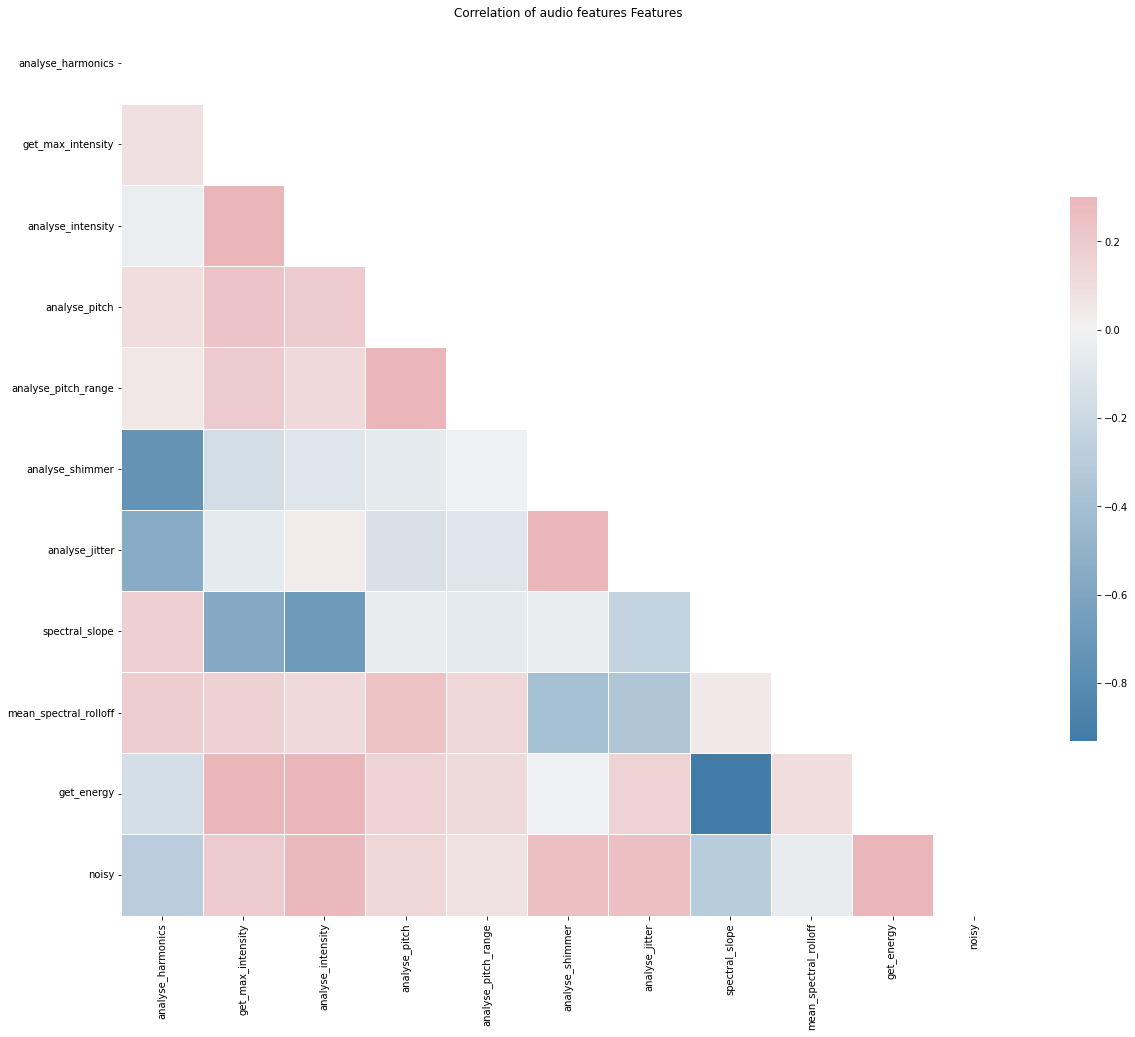

In [6]:
correlation_plot(data.drop(['parent_label', 'segment_label'], axis=1), "audio features")

There does not appear to be very clear groupings of correlations, we also saw significance in all of the features in the Anovas, so we will not attempt dimensionality reduction for modeling, however, we will to make our data verbalizable in 2 dimensions

Explained variation per principal component: [0.31614193 0.24536913 0.11788829 0.07419107 0.06742391]


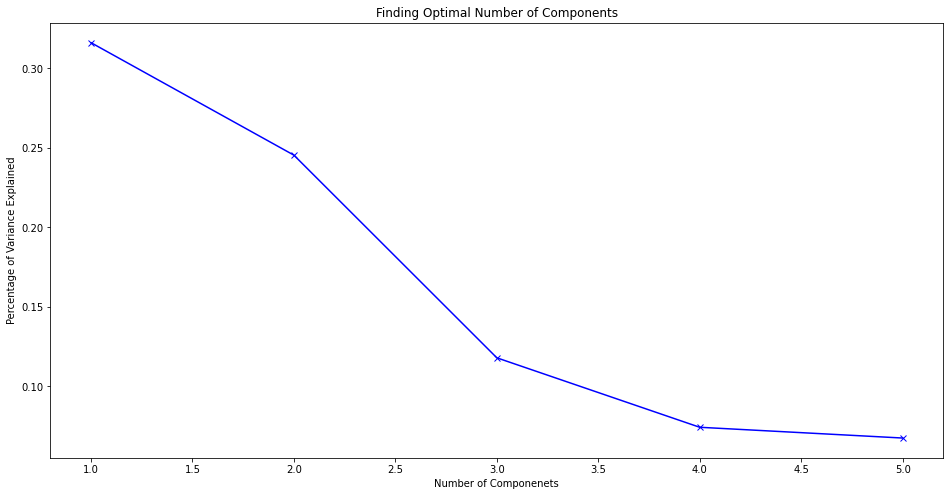

In [7]:
# Initialize PCA w/ n_components
pca = PCA(n_components=5)

# Fit the model & transform the features
principal_components = pca.fit_transform(data.drop(['parent_label', 'segment_label'], axis=1))

data["pca-one"] = principal_components[:,0]
data["pca-two"] = principal_components[:,1] 
data["pca-three"] = principal_components[:,2]

# How much of the variance in the dataset is explained? 
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plt.figure(figsize=(16,8))
num_components = [1,2,3,4,5]
plt.plot(num_components, pca.explained_variance_ratio_ , 'bx-')
plt.xlabel('Number of Componenets')
plt.ylabel('Percentage of Variance Explained')
plt.title('Finding Optimal Number of Components')
plt.show()

Three PCs would be a better choice to continue with modelling, however, we are only using this for plotting, so we will continue with two

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

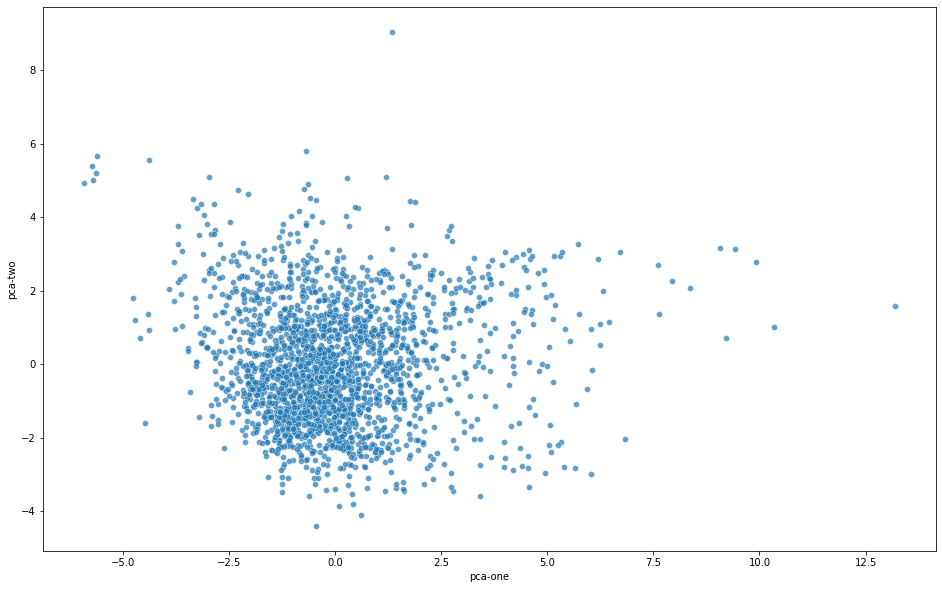

In [8]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    legend="full",
    data = data,
    alpha=0.7
)

Groupings don't appear particularity clear in any number, so lets try some modeling

See what number of cluster is suggested by K-means after PCA

In [9]:
# save first two PC as their own dataframe
pcs = {'pc1' : data["pca-one"], "pc2" : data["pca-two"]}
final_components = pd.DataFrame(pcs)

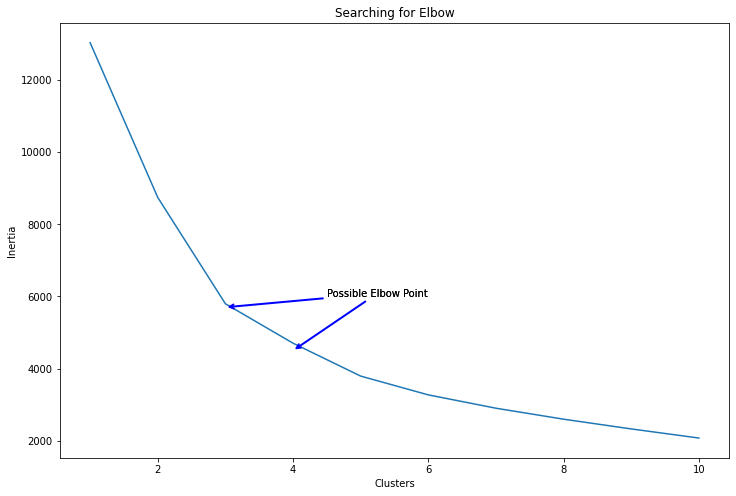

In [10]:
clusters = []

#collect inertia from 1-10 clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(final_components)
    cluster_labels = km.labels_
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow of possible choices for K
ax.annotate('Possible Elbow Point', xy=(4, 4500), xytext=(4.5, 6000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
ax.annotate('Possible Elbow Point', xy=(3, 5700), xytext=(4.5, 6000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

***3 or 4 could be a good choice, so it does appear our choice of 4 groupings is plausible given the data. Before standardization these are actually much more clear.***

But let's double check for all components without PCA

In [11]:
# save first two PC as their own dataframe
features = pd.DataFrame(data.drop(['parent_label', 'segment_label', 'pca-one', 'pca-two'], axis=1))

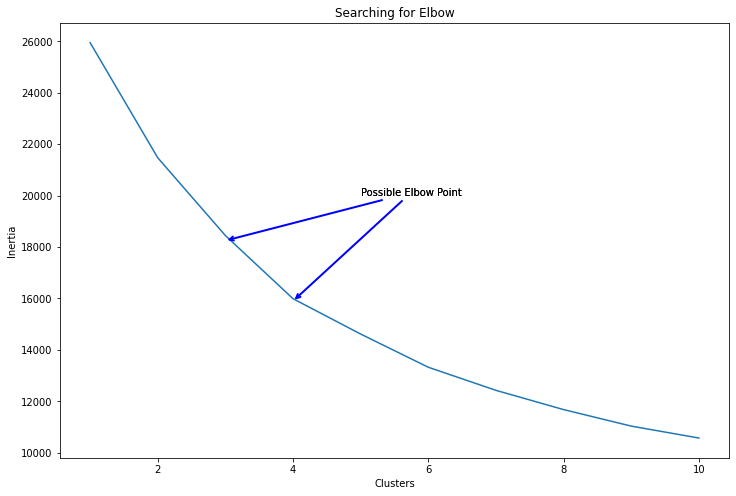

In [12]:
clusters = []

#collect inertia from 1-10 clusters
for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(features)
    cluster_labels = km.labels_
    clusters.append(km.inertia_)

fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow of possible choices for K
ax.annotate('Possible Elbow Point', xy=(4, 15900), xytext=(5, 20000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))
ax.annotate('Possible Elbow Point', xy=(3, 18250), xytext=(5, 20000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

### Results

- We dont get a particularly clear elbow.
- Without standardization there is a clear elbow.
- Therefore, K-means itself is not a good model to classify our data
- However, it does not refute our choice of groupings.
- **As we continue we will keep 4 labels, if we see difficulties we may combine labels 1 and 2.**